In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt

from src import mlp
from src import mlplocker
from src import mnist
from src import config

In [5]:
# Importing trained MLP model.
W1 = np.load(os.path.join(config.WEIGHTS_AND_BIASES_PATH + r'\mlp_0\npy', 'w1.npy'))
W2 = np.load(os.path.join(config.WEIGHTS_AND_BIASES_PATH + r'\mlp_0\npy', 'w2.npy'))
W3 = np.load(os.path.join(config.WEIGHTS_AND_BIASES_PATH + r'\mlp_0\npy', 'w3.npy'))
W4 = np.load(os.path.join(config.WEIGHTS_AND_BIASES_PATH + r'\mlp_0\npy', 'w_out.npy'))

b1 = np.load(os.path.join(config.WEIGHTS_AND_BIASES_PATH + r'\mlp_0\npy', 'b1.npy'))
b2 = np.load(os.path.join(config.WEIGHTS_AND_BIASES_PATH + r'\mlp_0\npy', 'b2.npy'))
b3 = np.load(os.path.join(config.WEIGHTS_AND_BIASES_PATH + r'\mlp_0\npy', 'b3.npy'))
b4 = np.load(os.path.join(config.WEIGHTS_AND_BIASES_PATH + r'\mlp_0\npy', 'b_out.npy'))

# Logic locking

In [6]:
trained_mlp = mlp.MLP(num_classes = config.NUM_CLASSES, learning_rate = config.LEARNING_RATE,
                    W1 = W1, W2 = W2, W3 = W3, W4 = W4,
                    b1 = b1, b2 = b2, b3 = b3, b4 = b4)
mnist = mnist.MNIST(config.TRAINING_IMAGES_FILEPATH,
              config.TRAINING_LABELS_FILEPATH,
              config.TEST_IMAGES_FILEPATH,
              config.TEST_LABELS_FILEPATH)
locking = mlplocker.MLPLocker(trained_mlp)

MNIST Data loaded and processed:
  x_train shape: (60000, 784), dtype: float32
  y_train shape: (60000, 10), dtype: float64
  x_test shape: (10000, 784), dtype: float32
  y_test shape: (10000, 10), dtype: float64


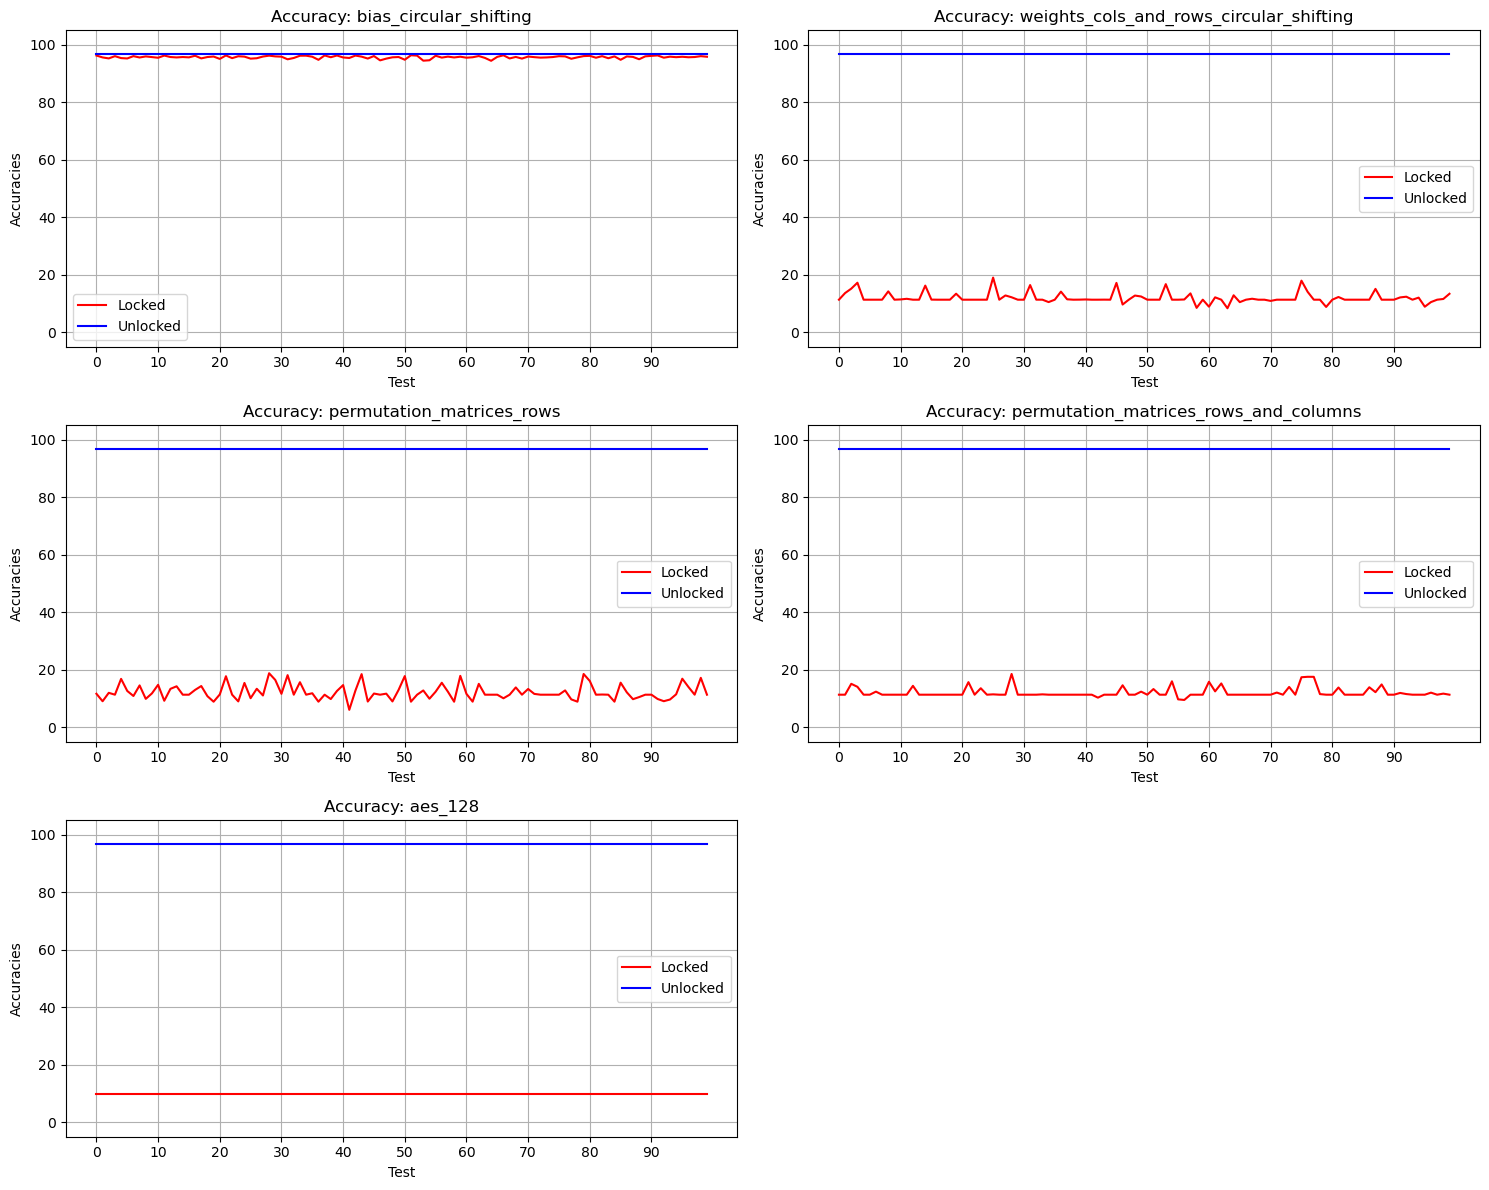

In [ ]:
locked_accuracies = {}
unlocked_accuracies = {}
tests = np.linspace(0, config.N_TESTS_PER_LL_APPROACH - 1, config.N_TESTS_PER_LL_APPROACH)

for approach in config.LOCKING_METHODS:
    locked_accuracy = np.zeros(config.N_TESTS_PER_LL_APPROACH)
    unlocked_accuracy = np.zeros(config.N_TESTS_PER_LL_APPROACH)
    
    for i in range(config.N_TESTS_PER_LL_APPROACH):
        if approach == 'aes_128':
            LOCKING_KEY = os.urandom(16)
        else:
            np.random.seed(None)
            LOCKING_KEY = np.random.randint(0, config.MAX_SHUFFLE, size=config.LOCKING_METHODS[approach])

        locking.lock(LOCKING_KEY, approach)
        locked_accuracy[i] = locking.test_locking(mnist.x_test, mnist.y_test)

        locking.unlock(LOCKING_KEY)
        unlocked_accuracy[i] = locking.test_locking(mnist.x_test, mnist.y_test)
        
    # Store results in dictionary
    locked_accuracies[approach] = locked_accuracy
    unlocked_accuracies[approach] = unlocked_accuracy
    
# Create 5 subplots 3x2 grid)
fig, axes = plt.subplots(3, 2, figsize=(15, 12))
axes = axes.flatten()

# Iterate through approaches and plot
for i, approach in enumerate(config.LOCKING_METHODS):
    ax = axes[i]
    ax.plot(tests, locked_accuracies[approach] * 100, linestyle='-', color='r', label='Locked')
    ax.plot(tests, unlocked_accuracies[approach] * 100, linestyle='-', color='b', label='Unlocked')

    ax.set_xticks(np.arange(0, config.N_TESTS_PER_LL_APPROACH, step=10))  # X-axis every 10 tests
    ax.set_ylim(-5, 105)  # Y-axis fixed range
    ax.set_xlabel('Test')
    ax.set_ylabel('Accuracies')
    ax.set_title(f'Accuracy: {approach}')
    ax.legend()
    ax.grid(True)
    
axes[-1].set_visible(False)


plt.tight_layout()
plt.show()